In [1]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.datasets import load_iris

In [2]:
np.random.seed(0)

In [3]:
x, y = load_iris(return_X_y=True)
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = x[:,[0,2]]
x.shape

(150, 2)

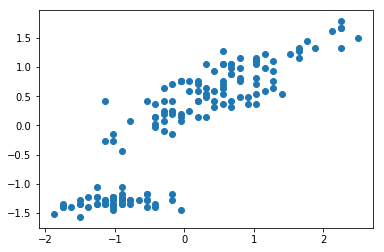

In [4]:
plt.scatter(x=x[:,0], y=x[:,1]);

In [112]:
def get_avg_knn_dist(values, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(values) # +1 because first neighbour is the point itself
    distances, indices = nbrs.kneighbors(values)
    
    return np.sort(distances[:,1:].mean(axis=1))

def get_distances_to_line(values):
    nPoints = len(values)
    allCoord = np.vstack((range(nPoints), values)).T

    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))

    vecFromFirst = allCoord - firstPoint

    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel

    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))

    return distToLine

In [182]:
# https://scikit-learn.org/stable/modules/classes.html#clustering-metrics
# https://scikit-learn.org/stable/modules/clustering.html

def evaluate_clustering(points, cluster_labels, print_info=True):
    #non_noise_inds = np.where(cluster_labels != -1)
    
    non_noise_points = points#[non_noise_inds]
    non_noise_clusters = cluster_labels#[non_noise_inds]
    
    pairwise_dist_matr = pairwise_distances(non_noise_points)
    
    silhouette = silhouette_score(pairwise_dist_matr, non_noise_clusters)
    calinski_harabasz = calinski_harabasz_score(non_noise_points, non_noise_clusters)
    davies_bouldin = davies_bouldin_score(non_noise_points, non_noise_clusters)
    
    if print_info:
        print('{:30}{: <16.3f}{:15}{}'.format('Silhouette Score:', 
                               silhouette, '[-1; 1]', 'higher is better'))
        print('{:30}{: <16.3f}{:15}{}'.format('Calinski Harabasz Score:', 
                               calinski_harabasz, '[0; +inf]', 'higher is better'))
        print('{:30}{: <16.3f}{:15}{}'.format('Davies Bouldin Score:', 
                               davies_bouldin, '[0; +inf]', 'lower is better'))
    
    return silhouette, davies_bouldin

In [128]:
def plotting(distToLine, avg_distances):
    idxOfBestPoint = np.argmax(distToLine)
    
    plt.figure(figsize=(10, 7))

    plt.plot(distToLine, label='Distance to Line', c='g')
    plt.plot(avg_distances, label='Sorted AVG KNN Distances', c='b')

    plt.xlim((0,len(avg_distances)))

    plt.axhline(y=avg_distances[idxOfBestPoint], xmin=0, xmax=idxOfBestPoint / len(avg_distances), c='r', alpha=0.3)
    plt.axvline(x=idxOfBestPoint, c='r', alpha=0.3, label='Knee point')
    plt.xlabel('Index')

    plt.title('Sorted Average Distance From Every Point to Its ' + str(N_NEIGHBOURS) + ' Neighbours')
    plt.xlabel('Index')
    plt.ylabel('Potential Epsilon')

    plt.legend()
    plt.grid()
    
    print('Knee Epsilon: ', avg_distances[idxOfBestPoint])

In [129]:
def plot_clustering(points, cluster_labels):
    plt.figure(figsize=(7, 4))
    plt.scatter(points[:, 0], points[:, 1], c=cluster_labels)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")

Knee Epsilon:  0.16614338753163302


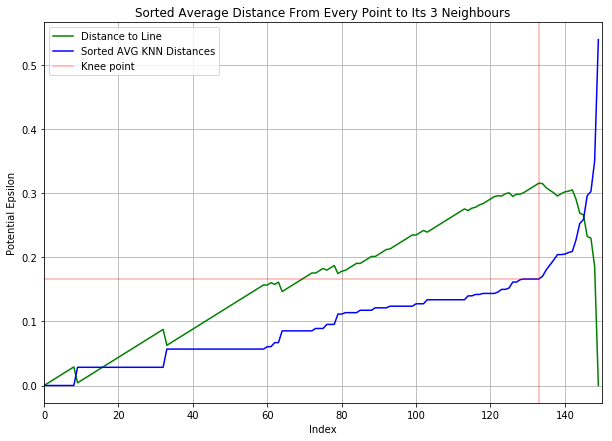

In [135]:
N_NEIGHBOURS = 3

avg_distances = get_avg_knn_dist(values=x, k=N_NEIGHBOURS)
distToLine = get_distances_to_line(avg_distances)

plotting(distToLine, avg_distances)

In [206]:
def hyperparams_tuning_dbscan(x, min_neighbours=2, max_neighbours=9, top_n=5):
    best_clusterings = []
    scores = set()

    for n_neighbours in range(min_neighbours,max_neighbours):

        avg_distances = get_avg_knn_dist(values=x, k=n_neighbours)
        distToLine = get_distances_to_line(avg_distances)

        idxOfBestPoint = np.argmax(distToLine)

        for eps in [avg_distances[idxOfBestPoint]]:#np.linspace(avg_distances[idxOfBestPoint]/2, avg_distances[idxOfBestPoint]*1.5, 30):
            dbscan = DBSCAN(eps=eps, min_samples=n_neighbours)
            clusters = dbscan.fit_predict(x)

            if len(np.unique(clusters[np.where(clusters>-1)])) > 1:
                silhouette, davies_bouldin = evaluate_clustering(x, clusters, print_info=False)
                #score = silhouette / davies_bouldin
                score = davies_bouldin

                best_clusterings = sorted(best_clusterings, key=lambda k: k['score'])

                if score not in scores:
                    if len(best_clusterings) < top_n or best_clusterings[0]['score'] < score:
                        best_clusterings.append({'score' : score, 
                                                 'clusters' : clusters, 
                                                 'n_neighbours' : n_neighbours, 
                                                 'eps' : eps,
                                                 'avg_distances' : avg_distances,
                                                 'distToLine' : distToLine})
                        scores.add(score)
                    if best_clusterings[0]['score'] < score:
                        deleted_dict = best_clusterings.pop(0)
                        if score in scores:
                            scores.remove(deleted_dict['score'])
    return sorted(best_clusterings, key=lambda k: k['score'])

In [211]:
def plot_dbscan_clusters(x, best_clusterings):
    for i in range(len(best_clusterings)):
        plot_clustering(x, best_clusterings[i]['clusters'])
        plt.show()
        silhouette, davies_bouldin = evaluate_clustering(points=x, 
                                                         cluster_labels=best_clusterings[i]['clusters'], 
                                                         print_info=True)
        print()
        print('{:30}{: <16.3f}{:15}{}'.format('Silhouette / Davies Bouldin:', 
                           silhouette / davies_bouldin, '', 'higher is better'))

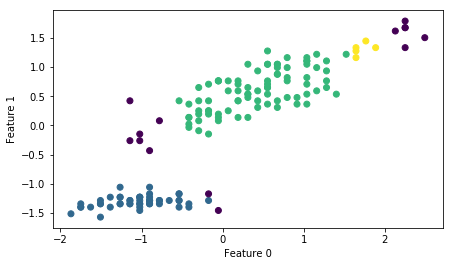

Silhouette Score:             0.468           [-1; 1]        higher is better
Calinski Harabasz Score:      111.912         [0; +inf]      higher is better
Davies Bouldin Score:         7.253           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.065                          higher is better


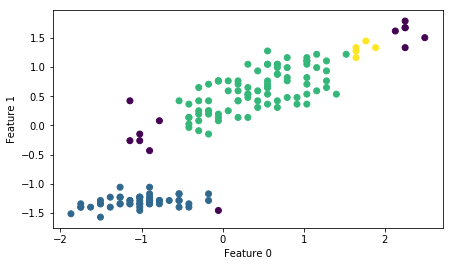

Silhouette Score:             0.478           [-1; 1]        higher is better
Calinski Harabasz Score:      116.631         [0; +inf]      higher is better
Davies Bouldin Score:         7.960           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.060                          higher is better


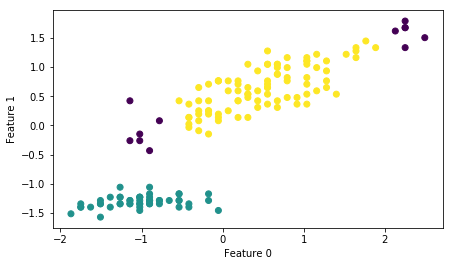

Silhouette Score:             0.578           [-1; 1]        higher is better
Calinski Harabasz Score:      159.273         [0; +inf]      higher is better
Davies Bouldin Score:         9.406           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.061                          higher is better


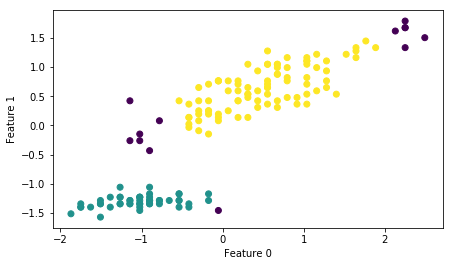

Silhouette Score:             0.568           [-1; 1]        higher is better
Calinski Harabasz Score:      149.964         [0; +inf]      higher is better
Davies Bouldin Score:         15.538          [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.037                          higher is better


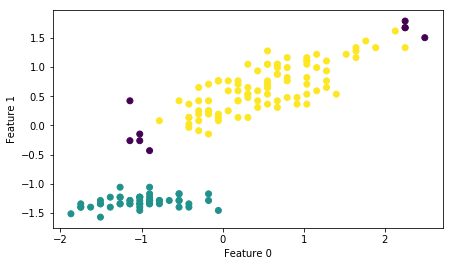

Silhouette Score:             0.566           [-1; 1]        higher is better
Calinski Harabasz Score:      158.521         [0; +inf]      higher is better
Davies Bouldin Score:         25.139          [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.023                          higher is better


In [177]:
best_clusterings = hyperparams_tuning_dbscan(x)
plot_dbscan_clusters(x, best_clusterings)

# K-Means

In [140]:
from sklearn.cluster import KMeans

In [141]:
x, y = load_iris(return_X_y=True)
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = x[:,[0,2]]
x.shape

(150, 2)

In [142]:
clusters = KMeans(n_clusters=2, n_init=20, random_state=0).fit_predict(x)

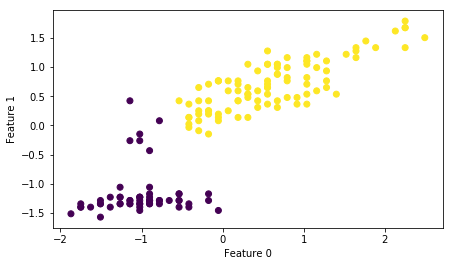

In [143]:
plot_clustering(x, clusters)

In [144]:
silhouette, davies_bouldin = evaluate_clustering(x, clusters, print_info=True)
print(silhouette / davies_bouldin, '\n')

Silhouette Score:             0.643           [-1; 1]        higher is better
Calinski Harabasz Score:      376.075         [0; +inf]      higher is better
Davies Bouldin Score:         0.471           [0; +inf]      lower is better
1.3668038556669166 



# Gaussian Mixture Models

In [145]:
from sklearn.mixture import GaussianMixture

In [146]:
clusters = GaussianMixture(n_components=2, n_init=20, random_state=0).fit_predict(x)

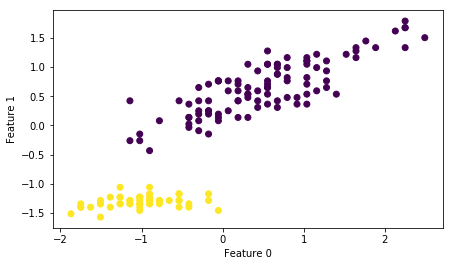

In [147]:
plot_clustering(x, clusters)

In [148]:
silhouette, davies_bouldin = evaluate_clustering(x, clusters, print_info=True)
print(silhouette / davies_bouldin, '\n')

Silhouette Score:             0.625           [-1; 1]        higher is better
Calinski Harabasz Score:      319.010         [0; +inf]      higher is better
Davies Bouldin Score:         0.451           [0; +inf]      lower is better
1.3840991938950074 



# Other Data

In [178]:
from sklearn import datasets

In [200]:
n_samples = 200
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

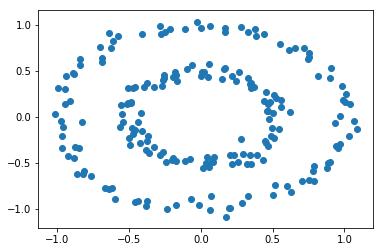

In [201]:
plt.scatter(x=noisy_circles[0][:,0], y=noisy_circles[0][:,1])

In [208]:
x = noisy_circles[0]

scaler = StandardScaler()
x = scaler.fit_transform(x)

Knee Epsilon:  0.1919876036934574


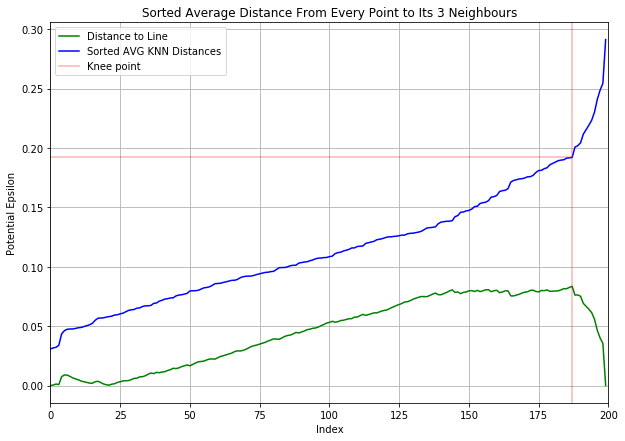

In [209]:
N_NEIGHBOURS = 3

avg_distances = get_avg_knn_dist(values=x, k=N_NEIGHBOURS)
distToLine = get_distances_to_line(avg_distances)

plotting(distToLine, avg_distances)

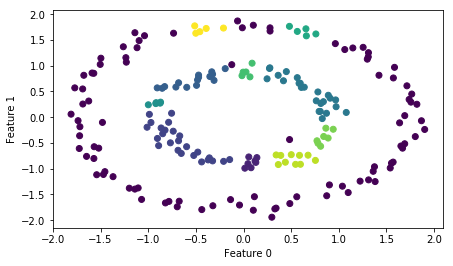

Silhouette Score:             -0.019          [-1; 1]        higher is better
Calinski Harabasz Score:      7.008           [0; +inf]      higher is better
Davies Bouldin Score:         2.023           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  -0.010                         higher is better


In [214]:
best_clusterings = hyperparams_tuning_dbscan(x, min_neighbours=3, max_neighbours=6)
plot_dbscan_clusters(x, best_clusterings)

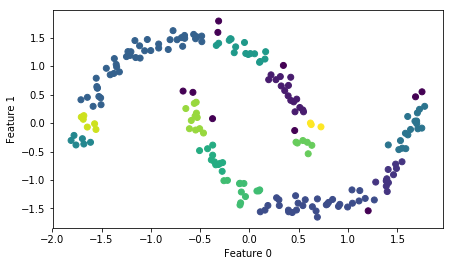

Silhouette Score:             0.388           [-1; 1]        higher is better
Calinski Harabasz Score:      146.197         [0; +inf]      higher is better
Davies Bouldin Score:         3.295           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.118                          higher is better


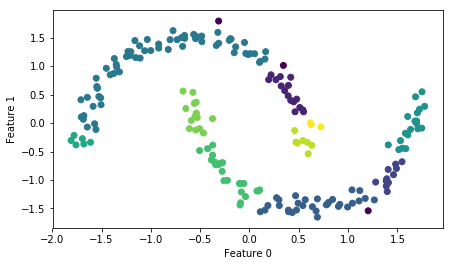

Silhouette Score:             0.374           [-1; 1]        higher is better
Calinski Harabasz Score:      118.173         [0; +inf]      higher is better
Davies Bouldin Score:         3.941           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.095                          higher is better


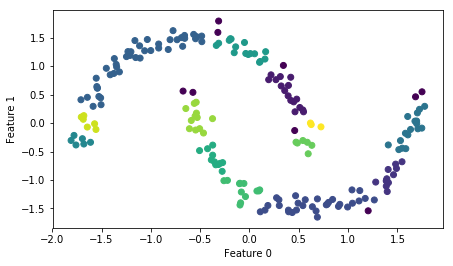

Silhouette Score:             0.395           [-1; 1]        higher is better
Calinski Harabasz Score:      149.387         [0; +inf]      higher is better
Davies Bouldin Score:         21.358          [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.018                          higher is better


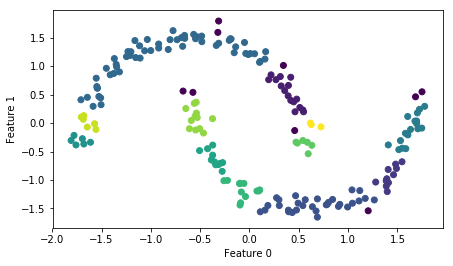

Silhouette Score:             0.369           [-1; 1]        higher is better
Calinski Harabasz Score:      113.547         [0; +inf]      higher is better
Davies Bouldin Score:         22.901          [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.016                          higher is better


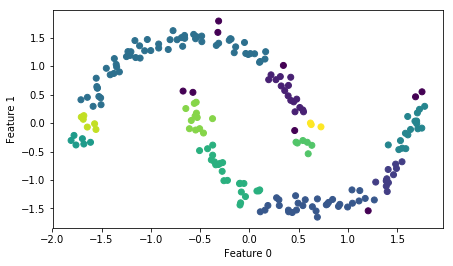

Silhouette Score:             0.358           [-1; 1]        higher is better
Calinski Harabasz Score:      118.360         [0; +inf]      higher is better
Davies Bouldin Score:         24.746          [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.014                          higher is better


In [191]:
x = noisy_moons[0]

scaler = StandardScaler()
x = scaler.fit_transform(x)

best_clusterings = hyperparams_tuning_dbscan(x)
plot_dbscan_clusters(x, best_clusterings)

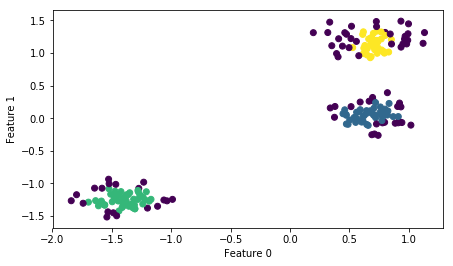

Silhouette Score:             0.259           [-1; 1]        higher is better
Calinski Harabasz Score:      114.446         [0; +inf]      higher is better
Davies Bouldin Score:         1.793           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.145                          higher is better


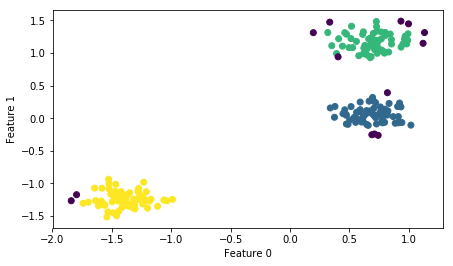

Silhouette Score:             0.740           [-1; 1]        higher is better
Calinski Harabasz Score:      758.781         [0; +inf]      higher is better
Davies Bouldin Score:         1.809           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.409                          higher is better


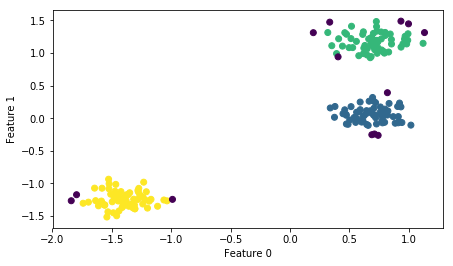

Silhouette Score:             0.738           [-1; 1]        higher is better
Calinski Harabasz Score:      688.595         [0; +inf]      higher is better
Davies Bouldin Score:         1.863           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.396                          higher is better


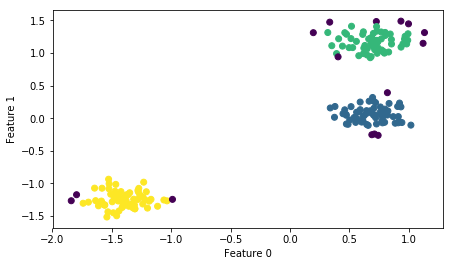

Silhouette Score:             0.725           [-1; 1]        higher is better
Calinski Harabasz Score:      636.110         [0; +inf]      higher is better
Davies Bouldin Score:         1.869           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.388                          higher is better


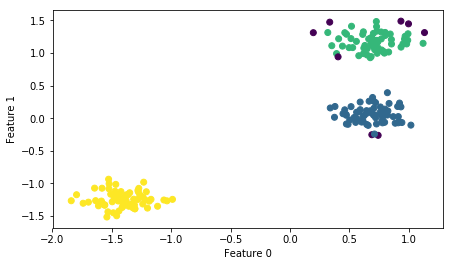

Silhouette Score:             0.732           [-1; 1]        higher is better
Calinski Harabasz Score:      1965.026        [0; +inf]      higher is better
Davies Bouldin Score:         2.247           [0; +inf]      lower is better

Silhouette / Davies Bouldin:  0.326                          higher is better


In [192]:
x = blobs[0]

scaler = StandardScaler()
x = scaler.fit_transform(x)

best_clusterings = hyperparams_tuning_dbscan(x)
plot_dbscan_clusters(x, best_clusterings)

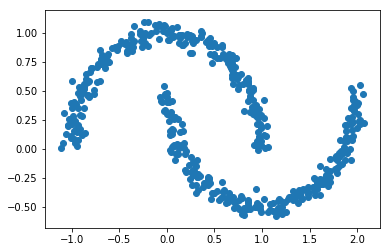

In [162]:
plt.scatter(x=noisy_moons[0][:,0], y=noisy_moons[0][:,1])

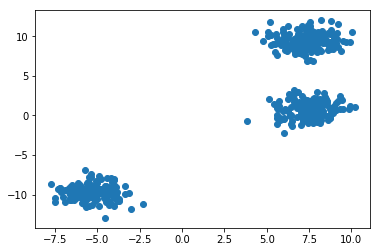

In [163]:
plt.scatter(x=blobs[0][:,0], y=blobs[0][:,1])